# Top overlapping annotations by weighted sum for saur cohort

In [1]:
import pandas as pd


pd.set_option("display.max_columns", None) # show all cols
pd.set_option('display.max_colwidth', None) # show full width of showing cols
pd.set_option("display.expand_frame_repr", False) # print cols side by side as it's supposed to be

## Read token information from bed files

In [2]:
import os
import pandas as pd
from pathlib import Path


bedDir = Path(os.environ['GENOMICS_DATA_BASE'], 'genome_nlp_tokens', 'bed_files', 'ECOLI')

bedDfList = []
for bedFile in os.listdir(bedDir):
    tubeid = bedFile.split('.')[0].split('_')[0]
    tokensDf = pd.read_csv(Path(bedDir, bedFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score'])
    tokensDf['tube_id'] = tubeid
    bedDfList.append(tokensDf)

bedDf = pd.concat(bedDfList, ignore_index=True)
bedDf

,contig_id,start_position,end_position,tokens,score,tube_id
0,1,1,3,GAA,0.024555,AH21B049
1,1,4,12,AAACCCCGG,0.019281,AH21B049
2,1,13,17,TCAAT,0.042749,AH21B049
3,1,18,22,AAGGC,0.058446,AH21B049
4,1,23,27,CGGGG,-0.002272,AH21B049
...,...,...,...,...,...,...
247349726,5,259913,259920,GCTACCCG,0.012245,ALF22C077
247349727,5,259921,259928,TTGGTGTG,0.000125,ALF22C077
247349728,5,259929,259938,CCTGTTCCGT,-0.000540,ALF22C077
247349729,5,259939,259942,GGCC,0.024973,ALF22C077


<Axes: >

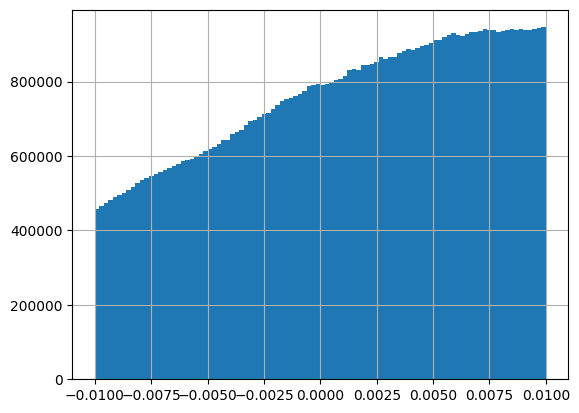

In [3]:
bedDf[(bedDf.score > -0.01) & (bedDf.score < 0.01)].score.hist(bins=100)

In [4]:
bedDf['token_length'] = bedDf.tokens.apply(lambda x: len(x))
bedDf

,contig_id,start_position,end_position,tokens,score,tube_id,token_length
0,1,1,3,GAA,0.024555,AH21B049,3
1,1,4,12,AAACCCCGG,0.019281,AH21B049,9
2,1,13,17,TCAAT,0.042749,AH21B049,5
3,1,18,22,AAGGC,0.058446,AH21B049,5
4,1,23,27,CGGGG,-0.002272,AH21B049,5
...,...,...,...,...,...,...,...
247349726,5,259913,259920,GCTACCCG,0.012245,ALF22C077,8
247349727,5,259921,259928,TTGGTGTG,0.000125,ALF22C077,8
247349728,5,259929,259938,CCTGTTCCGT,-0.000540,ALF22C077,10
247349729,5,259939,259942,GGCC,0.024973,ALF22C077,4


In [5]:
len(bedDf.tokens.unique())

31990

In [6]:
highscoreCutoff = bedDf.score.mean() + 3 * bedDf.score.std()
highscoreCutoff

np.float64(0.10044996853550375)

In [7]:
highscoreDf = bedDf[bedDf.score > highscoreCutoff]
highscoreDf

,contig_id,start_position,end_position,tokens,score,tube_id,token_length
790,1,5456,5461,TTCCGG,0.109817,AH21B049,6
1113,1,7709,7713,CCGAC,0.111683,AH21B049,5
1141,1,7901,7906,GGTTTT,0.126671,AH21B049,6
1147,1,7939,7943,GACAG,0.138056,AH21B049,5
1544,1,10694,10701,CCCGACGG,0.119595,AH21B049,8
...,...,...,...,...,...,...,...
247348343,5,250450,250457,CCCTTTTT,0.104689,ALF22C077,8
247348387,5,250737,250741,ACAGA,0.114884,ALF22C077,5
247349058,5,255352,255357,GAAAAA,0.100641,ALF22C077,6
247349081,5,255503,255508,ACGCTG,0.112193,ALF22C077,6


In [8]:
len(highscoreDf.tokens.unique())

13592

In [9]:
highscoreDf.shape

(3266793, 7)

<Axes: >

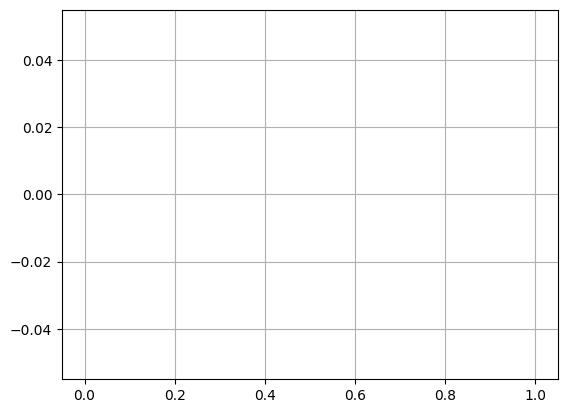

In [10]:
highscoreDf[(highscoreDf.score < 0.05)].score.hist(bins=100)

In [11]:
highscoreDf.token_length.value_counts()

token_length
6     1005832
7      585361
5      449264
8      339503
9      263575
4      262709
3      186469
10      92597
2       40984
11      30865
1        4650
12       2730
16       1991
15        152
13        102
14          9
Name: count, dtype: int64

<Axes: xlabel='token_length', ylabel='Count'>

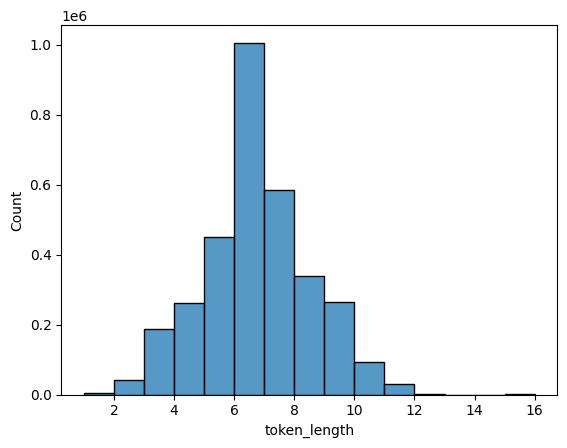

In [12]:
import seaborn as sns

sns.histplot(highscoreDf.token_length, binwidth=1)

## Read bed files containing overlapping tokens and attribution scores

In [13]:
from tqdm import tqdm

import os
import pandas as pd
from pathlib import Path


annotationOverlappingFilesDir = Path(os.environ['GENOMICS_DATA_BASE'], 'genome_nlp_tokens', 'overlapping_with_annotations', 'ECOLI')

annotationOverlappingDfList = []
for annotationOverlappingFile in tqdm(os.listdir(annotationOverlappingFilesDir)):
    df = pd.read_csv(Path(annotationOverlappingFilesDir, annotationOverlappingFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score', 'feature_type', 'id', 'name', 'gene', 'atributes'])
    df = df[df.feature_type.isin(['CDS', 'ncRNA', 'oriC', 'regulatory_region', 'oriT'])]
    df['tube_code'] = [annotationOverlappingFile.split('_')[0]]*df.shape[0]
    df = df[df.tokens.apply(lambda x: (len(x) >= 5))].reset_index()
    df['gene'] = df.gene.str.lower()
    annotationOverlappingDfList.append(df)
annotationOverlappingDf = pd.concat(annotationOverlappingDfList, ignore_index=True)
annotationOverlappingDf = annotationOverlappingDf.drop_duplicates()
annotationOverlappingDf

100%|██████████| 358/358 [08:13<00:00,  1.38s/it]


,index,contig_id,start_position,end_position,tokens,score,feature_type,id,name,gene,atributes,tube_code
0,0,1,665,671,GAATCAT,0.037687,CDS,IGMLFD_00005,Uncharacterized deacetylase YaiS,yais,"ID=IGMLFD_00005;Name=Uncharacterized deacetylase YaiS;locus_tag=IGMLFD_00005;product=Uncharacterized deacetylase YaiS;Dbxref=COG:COG2120,COG:G,EC:3.-.-.-,GO:0016811,RefSeq:WP_000362014.1,SO:0001217,UniParc:UPI0000DACD3F,UniRef:UniRef100_A0A0D8VZB7,UniRef:UniRef50_P71311,UniRef:UniRef90_P71311;gene=yaiS",AH19C036
1,1,1,672,680,TTTATGAAT,0.023426,CDS,IGMLFD_00005,Uncharacterized deacetylase YaiS,yais,"ID=IGMLFD_00005;Name=Uncharacterized deacetylase YaiS;locus_tag=IGMLFD_00005;product=Uncharacterized deacetylase YaiS;Dbxref=COG:COG2120,COG:G,EC:3.-.-.-,GO:0016811,RefSeq:WP_000362014.1,SO:0001217,UniParc:UPI0000DACD3F,UniRef:UniRef100_A0A0D8VZB7,UniRef:UniRef50_P71311,UniRef:UniRef90_P71311;gene=yaiS",AH19C036
2,3,1,684,689,AAAACC,0.024358,CDS,IGMLFD_00005,Uncharacterized deacetylase YaiS,yais,"ID=IGMLFD_00005;Name=Uncharacterized deacetylase YaiS;locus_tag=IGMLFD_00005;product=Uncharacterized deacetylase YaiS;Dbxref=COG:COG2120,COG:G,EC:3.-.-.-,GO:0016811,RefSeq:WP_000362014.1,SO:0001217,UniParc:UPI0000DACD3F,UniRef:UniRef100_A0A0D8VZB7,UniRef:UniRef50_P71311,UniRef:UniRef90_P71311;gene=yaiS",AH19C036
3,4,1,690,698,TTCACCCAG,0.031550,CDS,IGMLFD_00005,Uncharacterized deacetylase YaiS,yais,"ID=IGMLFD_00005;Name=Uncharacterized deacetylase YaiS;locus_tag=IGMLFD_00005;product=Uncharacterized deacetylase YaiS;Dbxref=COG:COG2120,COG:G,EC:3.-.-.-,GO:0016811,RefSeq:WP_000362014.1,SO:0001217,UniParc:UPI0000DACD3F,UniRef:UniRef100_A0A0D8VZB7,UniRef:UniRef50_P71311,UniRef:UniRef90_P71311;gene=yaiS",AH19C036
4,5,1,699,708,ATCGCTATTG,0.008409,CDS,IGMLFD_00005,Uncharacterized deacetylase YaiS,yais,"ID=IGMLFD_00005;Name=Uncharacterized deacetylase YaiS;locus_tag=IGMLFD_00005;product=Uncharacterized deacetylase YaiS;Dbxref=COG:COG2120,COG:G,EC:3.-.-.-,GO:0016811,RefSeq:WP_000362014.1,SO:0001217,UniParc:UPI0000DACD3F,UniRef:UniRef100_A0A0D8VZB7,UniRef:UniRef50_P71311,UniRef:UniRef90_P71311;gene=yaiS",AH19C036
...,...,...,...,...,...,...,...,...,...,...,...,...
83835702,301834,5,357109,357119,CGGCAGACGAA,0.017858,CDS,KCGHAI_11840,Phage-related protein%2C tail assembly protein I,NaN,"ID=KCGHAI_11840;Name=Phage-related protein%2C tail assembly protein I;locus_tag=KCGHAI_11840;product=Phage-related protein%2C tail assembly protein I;Dbxref=COG:COG4723,COG:X,RefSeq:WP_000847668.1,SO:0001217,UniParc:UPI00016DBD2D,UniRef:UniRef100_A0A0A6RKN9,UniRef:UniRef50_F4V9K2,UniRef:UniRef90_A0A369FJA2",AH19F069
83835703,301835,5,357120,357125,GGGGAT,0.030131,CDS,KCGHAI_11840,Phage-related protein%2C tail assembly protein I,NaN,"ID=KCGHAI_11840;Name=Phage-related protein%2C tail assembly protein I;locus_tag=KCGHAI_11840;product=Phage-related protein%2C tail assembly protein I;Dbxref=COG:COG4723,COG:X,RefSeq:WP_000847668.1,SO:0001217,UniParc:UPI00016DBD2D,UniRef:UniRef100_A0A0A6RKN9,UniRef:UniRef50_F4V9K2,UniRef:UniRef90_A0A369FJA2",AH19F069
83835704,301836,5,357126,357131,GGTGGT,0.045921,CDS,KCGHAI_11840,Phage-related protein%2C tail assembly protein I,NaN,"ID=KCGHAI_11840;Name=Phage-related protein%2C tail assembly protein I;locus_tag=KCGHAI_11840;product=Phage-related protein%2C tail assembly protein I;Dbxref=COG:COG4723,COG:X,RefSeq:WP_000847668.1,SO:0001217,UniParc:UPI00016DBD2D,UniRef:UniRef100_A0A0A6RKN9,UniRef:UniRef50_F4V9K2,UniRef:UniRef90_A0A369FJA2",AH19F069
83835705,301837,5,357132,357138,CAGGTTG,-0.022747,CDS,KCGHAI_11840,Phage-related protein%2C tail assembly protein I,NaN,"ID=KCGHAI_11840;Name=Phage-related protein%2C tail assembly protein I;locus_tag=KCGHAI_11840;product=Phage-related protein%2C tail assembly protein I;Dbxref=COG:COG4723,COG:X,RefSeq:WP_000847668.1,SO:0001217,UniParc:UPI00016DBD2D,UniRef:UniRef100_A0A0A6RKN9,UniRef:UniRef50_F4V9K2,UniRef:UniRef90_A0A369FJA2",AH19F069


In [14]:
from tqdm import tqdm


amrfinderDir = Path(os.environ['GENOMICS_DATA_BASE'], 'amrfinder')

amrOverlappingDfList = []
for tubeId in tqdm(bedDf.tube_id.unique()):
    tubeidHighscoreDf = highscoreDf[highscoreDf.tube_id == tubeId]
    amrfinderFile = Path(amrfinderDir, tubeId + '_amr_results.txt')
    if(amrfinderFile.exists()):
        amrfinderDf = pd.read_csv(amrfinderFile, sep='\t')
        mergedDf = tubeidHighscoreDf.merge(
            amrfinderDf,
            how='inner',
            left_on = ['contig_id'],
            right_on = ['Contig id'],
        )
        mergedDf['tube_code'] = tubeId
        tubeidOverlappingDf = mergedDf[(mergedDf.start_position >= mergedDf.Start) & (mergedDf.end_position <= mergedDf.Stop)]
        amrOverlappingDfList.append(tubeidOverlappingDf)

amrOverlappingDf = pd.concat(amrOverlappingDfList, ignore_index=True)
amrOverlappingDf

100%|██████████| 861/861 [02:11<00:00,  6.53it/s]


,contig_id,start_position,end_position,tokens,score,tube_id,token_length,Protein identifier,Contig id,Start,Stop,Strand,Gene symbol,Sequence name,Scope,Element type,Element subtype,Class,Subclass,Method,Target length,Reference sequence length,% Coverage of reference sequence,% Identity to reference sequence,Alignment length,Accession of closest sequence,Name of closest sequence,HMM id,HMM description,tube_code
0,1,395434,395439,GAACGT,0.107013,AH21B049,6,NaN,1,394617,395984,+,ibeA,putative intracellular survival FAD-dependent oxidoreductase IbeA,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,456,456,100.0,97.81,456,AAF98391.2,putative intracellular survival FAD-dependent oxidoreductase IbeA,NaN,NaN,AH21B049
1,4,10223,10231,TTTCACATC,0.125651,AH21B049,9,NaN,4,5811,10370,-,sslE,lipoprotein metalloprotease SslE,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,1520,1520,100.0,92.43,1520,ADE89421.1,lipoprotein metalloprotease SslE,NaN,NaN,AH21B049
2,4,10271,10276,GGAGGA,0.156269,AH21B049,6,NaN,4,5811,10370,-,sslE,lipoprotein metalloprotease SslE,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,1520,1520,100.0,92.43,1520,ADE89421.1,lipoprotein metalloprotease SslE,NaN,NaN,AH21B049
3,4,10299,10304,CAACCG,0.104414,AH21B049,6,NaN,4,5811,10370,-,sslE,lipoprotein metalloprotease SslE,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,1520,1520,100.0,92.43,1520,ADE89421.1,lipoprotein metalloprotease SslE,NaN,NaN,AH21B049
4,4,322635,322639,ACCGA,0.120406,AH21B049,5,NaN,4,322345,325446,+,acrF,multidrug efflux RND transporter permease subunit AcrF,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,1034,1034,100.0,99.52,1034,AAC76298.1,multidrug efflux RND transporter permease subunit AcrF,NaN,NaN,AH21B049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14814,5,348217,348226,CTGGGCTGGG,0.121704,AH19C036,10,NaN,5,346159,349260,+,acrF,multidrug efflux RND transporter permease subunit AcrF,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,1034,1034,100.0,99.52,1034,AAC76298.1,multidrug efflux RND transporter permease subunit AcrF,NaN,NaN,AH19C036
14815,5,348237,348242,CTGACC,0.110060,AH19C036,6,NaN,5,346159,349260,+,acrF,multidrug efflux RND transporter permease subunit AcrF,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,1034,1034,100.0,99.52,1034,AAC76298.1,multidrug efflux RND transporter permease subunit AcrF,NaN,NaN,AH19C036
14816,5,348254,348260,CCAGTTG,0.100546,AH19C036,7,NaN,5,346159,349260,+,acrF,multidrug efflux RND transporter permease subunit AcrF,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,1034,1034,100.0,99.52,1034,AAC76298.1,multidrug efflux RND transporter permease subunit AcrF,NaN,NaN,AH19C036
14817,5,348533,348535,CGC,0.107089,AH19C036,3,NaN,5,346159,349260,+,acrF,multidrug efflux RND transporter permease subunit AcrF,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,1034,1034,100.0,99.52,1034,AAC76298.1,multidrug efflux RND transporter permease subunit AcrF,NaN,NaN,AH19C036


In [15]:
overlappingDf = pd.concat(
    [
        annotationOverlappingDf[['contig_id', 'start_position', 'end_position', 'tokens', 'score', 'gene', 'name', 'tube_code']],
        amrOverlappingDf[['contig_id', 'start_position', 'end_position', 'tokens', 'score', 'Gene symbol', 'Sequence name', 'tube_code']].rename(columns={'Gene symbol': 'gene', 'Sequence name': 'name'})
    ],
    names=['contig_id', 'start_position', 'end_position', 'tokens', 'gene'],
    ignore_index=False
)
overlappingDf

,contig_id,start_position,end_position,tokens,score,gene,name,tube_code
0,1,665,671,GAATCAT,0.037687,yais,Uncharacterized deacetylase YaiS,AH19C036
1,1,672,680,TTTATGAAT,0.023426,yais,Uncharacterized deacetylase YaiS,AH19C036
2,1,684,689,AAAACC,0.024358,yais,Uncharacterized deacetylase YaiS,AH19C036
3,1,690,698,TTCACCCAG,0.031550,yais,Uncharacterized deacetylase YaiS,AH19C036
4,1,699,708,ATCGCTATTG,0.008409,yais,Uncharacterized deacetylase YaiS,AH19C036
...,...,...,...,...,...,...,...,...
14814,5,348217,348226,CTGGGCTGGG,0.121704,acrF,multidrug efflux RND transporter permease subunit AcrF,AH19C036
14815,5,348237,348242,CTGACC,0.110060,acrF,multidrug efflux RND transporter permease subunit AcrF,AH19C036
14816,5,348254,348260,CCAGTTG,0.100546,acrF,multidrug efflux RND transporter permease subunit AcrF,AH19C036
14817,5,348533,348535,CGC,0.107089,acrF,multidrug efflux RND transporter permease subunit AcrF,AH19C036


## Get overlapping tokens for high-score tokens

In [16]:
highscoreTokenOverlapsDf = overlappingDf.merge(
    highscoreDf[['contig_id', 'start_position', 'end_position', 'tokens']],
    on=['contig_id', 'start_position', 'end_position', 'tokens'],
    how='inner',
)
highscoreTokenOverlapsDf

,contig_id,start_position,end_position,tokens,score,gene,name,tube_code
0,1,3240,3248,ACACCAGAT,0.111607,taub,taurine ABC transporter ATP-binding subunit,AH19C036
1,1,3240,3248,ACACCAGAT,0.111607,taub,taurine ABC transporter ATP-binding subunit,AH19C036
2,1,3240,3248,ACACCAGAT,0.111607,taub,taurine ABC transporter ATP-binding subunit,AH19C036
3,1,3240,3248,ACACCAGAT,0.111607,taub,taurine ABC transporter ATP-binding subunit,AH19C036
4,1,3240,3248,ACACCAGAT,0.111607,taub,taurine ABC transporter ATP-binding subunit,AH19C036
...,...,...,...,...,...,...,...,...
2195216,5,348217,348226,CTGGGCTGGG,0.121704,acrF,multidrug efflux RND transporter permease subunit AcrF,AH19C036
2195217,5,348237,348242,CTGACC,0.110060,acrF,multidrug efflux RND transporter permease subunit AcrF,AH19C036
2195218,5,348254,348260,CCAGTTG,0.100546,acrF,multidrug efflux RND transporter permease subunit AcrF,AH19C036
2195219,5,348533,348535,CGC,0.107089,acrF,multidrug efflux RND transporter permease subunit AcrF,AH19C036


## Calculate weighted sum for all the genes overlapping with high-score tokens

In [17]:
import numpy as np


geneWeightedsumDf = highscoreTokenOverlapsDf.groupby(by=['gene']).agg({'score': np.sum}).reset_index().rename(columns={'score': 'weighted_sum'})
geneWeightedsumDf

/tmp/ipykernel_3110/2423154480.py:4: FutureWarning: The provided callable <function sum at 0x7f262419c3a0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  geneWeightedsumDf = highscoreTokenOverlapsDf.groupby(by=['gene']).agg({'score': np.sum}).reset_index().rename(columns={'score': 'weighted_sum'})


,gene,weighted_sum
0,6s,4.710385
1,aac(3)-IId,0.842917
2,aadA1,1.352251
3,aada1,0.344464
4,aaea,96.664124
...,...,...
4421,zoro,1.250781
4422,zras,0.105720
4423,zupt,53.861828
4424,zur,2.640610


## Visualise weighted sum

<Axes: xlabel='weighted_sum', ylabel='Count'>

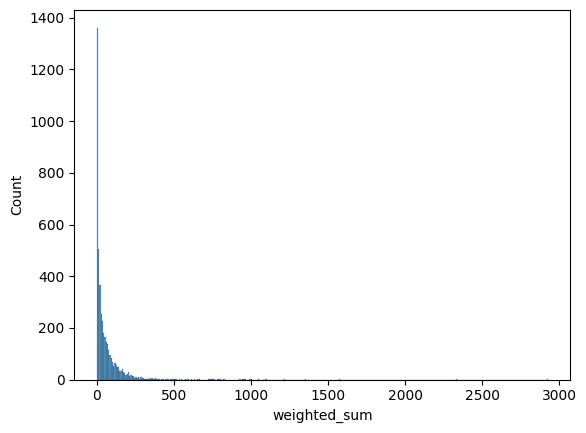

In [18]:
import seaborn as sns


sns.histplot(geneWeightedsumDf.weighted_sum)

## Top genes based on the weighted sum

In [19]:
geneWeightedsumDf.sort_values(by=['weighted_sum'], ascending=False)[:20]

,gene,weighted_sum
42,acrs,2926.868077
3987,yhdz,2333.133975
35,acrF,1573.600212
20,accc,1356.848448
363,ccma,1214.694417
1060,ftsh,1094.733786
1383,hsca,1052.384850
3985,yhdx,1004.086351
3979,yhdj,990.997389
3055,tref,963.444221


## Create gene-type lookup table from amrfinderplus annotations

In [20]:
import os

import pandas as pd

from pathlib import Path


amrfinderDir = Path(os.environ['GENOMICS_DATA_BASE'], 'amrfinder')

amrfinderDfList = []
for amrfinderFile in os.listdir(amrfinderDir):
    amrfinderDf = pd.read_csv(Path(amrfinderDir, amrfinderFile), sep='\t')
    amrfinderDfList.append(amrfinderDf)

allAmrfinderDf = pd.concat(amrfinderDfList, ignore_index=True)
allAmrfinderDf

/tmp/ipykernel_3110/536070399.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  allAmrfinderDf = pd.concat(amrfinderDfList, ignore_index=True)


,Protein identifier,Contig id,Start,Stop,Strand,Gene symbol,Sequence name,Scope,Element type,Element subtype,Class,Subclass,Method,Target length,Reference sequence length,% Coverage of reference sequence,% Identity to reference sequence,Alignment length,Accession of closest sequence,Name of closest sequence,HMM id,HMM description
0,NaN,1,83926,85452,-,aur,zinc metalloproteinase aureolysin,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,509,509,100.00,99.41,509,EHO93748.1,zinc metalloproteinase aureolysin,NaN,NaN
1,NaN,1,128415,129464,+,icaC,polysaccharide intercellular adhesin biosynthesis/export protein IcaC,plus,VIRULENCE,VIRULENCE,NaN,NaN,EXACTX,350,350,100.00,100.00,350,AUU58561.1,polysaccharide intercellular adhesin biosynthesis/export protein IcaC,NaN,NaN
2,NaN,1,150950,154498,-,cna,collagen adhesin Cna,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,1183,1183,100.00,98.31,1183,BAB96477.1,collagen adhesin Cna,NaN,NaN
3,NaN,1,277464,278813,+,tet(38),tetracycline efflux MFS transporter Tet(38),core,AMR,AMR,TETRACYCLINE,TETRACYCLINE,EXACTX,450,450,100.00,100.00,450,WP_001100300.1,tetracycline efflux MFS transporter Tet(38),NaN,NaN
4,NaN,1,505300,506652,+,mepA,multidrug efflux MATE transporter MepA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,451,451,100.00,99.33,451,BAB41547.1,multidrug efflux MATE transporter MepA,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57610,NaN,17,83399,84580,-,emrD,multidrug efflux MFS transporter EmrD,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,394,394,100.00,99.24,394,ACN65732.1,multidrug efflux MFS transporter EmrD,NaN,NaN
57611,NaN,2,213498,214724,-,kdeA,multidrug efflux MFS transporter KdeA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,409,410,99.76,99.02,409,ABR76310.1,multidrug efflux MFS transporter KdeA,NaN,NaN
57612,NaN,3,59710,60882,+,oqxA,multidrug efflux RND transporter periplasmic adaptor subunit OqxA,core,AMR,AMR,PHENICOL/QUINOLONE,PHENICOL/QUINOLONE,BLASTX,391,391,100.00,99.23,391,WP_002914189.1,multidrug efflux RND transporter periplasmic adaptor subunit OqxA,NaN,NaN
57613,NaN,3,60909,64058,+,oqxB9,multidrug efflux RND transporter permease subunit OqxB9,core,AMR,AMR,PHENICOL/QUINOLONE,PHENICOL/QUINOLONE,ALLELEX,1050,1050,100.00,100.00,1050,WP_012967412.1,multidrug efflux RND transporter permease subunit OqxB9,NaN,NaN


In [21]:
genetypeLookupDf = allAmrfinderDf[['Gene symbol', 'Element type']].drop_duplicates()
genetypeLookupDf['Gene symbol'] = genetypeLookupDf['Gene symbol'].str.lower()
genetypeLookupDf

,Gene symbol,Element type
0,aur,VIRULENCE
1,icac,VIRULENCE
2,cna,VIRULENCE
3,tet(38),AMR
4,mepa,AMR
...,...,...
55837,blapdc-58,AMR
56358,blaact-49,AMR
56951,blandm-4,AMR
56963,aac(6')-ib-cr,AMR


## Read vfdb info

In [22]:
import os
import pandas as pd
from pathlib import Path


vfdbInfoFile = Path(os.environ['GENOMICS_DATA_BASE'], 'misc', 'VFDB_info.csv')
vfdbInfoDf = pd.read_csv(vfdbInfoFile)
vfdbInfoDf['Label'] = vfdbInfoDf['Label'].str.lower()
vfdbInfoDf

,Column,ID,Label,Description,Source,Class
0,1,c0393,vat,hemoglobin protease,Escherichia coli O6:K2:H1 CFT073 (UPEC),Autotransporters
1,2,APECO1_O1CoBM73,tsh,Tsh,Escherichia coli O1:K1:H7 (APEC),Autotransporters
2,3,Q673F0_ECOLX,rpea,putative SPATE autotransporter; similar to the SPATE proteins,Escherichia coli plasmid pRAP strain REPEC 83/39,Autotransporters
3,4,ECSF_4010,ecsf_4010,phage protein,Escherichia coli SE15,Autotransporters
4,5,EcSMS35_3921,ecsms35_3921,outer membrane autotransporter,Escherichia coli SMS-3-5 (environmental),Autotransporters
...,...,...,...,...,...,...
249,250,c5077,yddo,ABC transporter ATP-binding protein,Escherichia coli O6:K2:H1 CFT073 (UPEC),UPEC specific genes
250,251,c5078,c5078,oligopeptide ABC transporter,Escherichia coli O6:K2:H1 CFT073 (UPEC),UPEC specific genes
251,252,c5079,yddq,ABC transporter permease,Escherichia coli O6:K2:H1 CFT073 (UPEC),UPEC specific genes
252,253,c5080,yddr,ABC transporter permease,Escherichia coli O6:K2:H1 CFT073 (UPEC),UPEC specific genes


## Read vf collection

In [23]:
import os
import pandas as pd
from pathlib import Path


vfCollectionDescriptionFile = Path(os.environ['GENOMICS_DATA_BASE'], 'misc', 'ecoli_VF_collection_description.tsv')
vfCollectionDescriptionDf = pd.read_csv(vfCollectionDescriptionFile, sep='\t')
vfCollectionDescriptionDf['gene'] = vfCollectionDescriptionDf['gene'].str.lower()
vfCollectionDescriptionDf

,gene,locus tag,accession number (protein_id),description,reference,source,class
0,aap,EC042_pAA055,NaN,dispersin,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
1,aata,EC042_pAA008,NaN,dispersin secretion locus ABC transporter,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
2,aatb,EC042_pAA009,NaN,dispersin secretion locus ABC transporter,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
3,aatc,EC042_pAA010,NaN,dispersin secretion locus ABC transporter,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
4,aatd,EC042_pAA011,NaN,dispersin secretion locus ABC transporter,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
...,...,...,...,...,...,...,...
1064,lngj,NaN,ABU50049,"longus pili, coli surface antigen CS20",Escherichia coli O8:H9 E9034A (ETEC),VFDB R3,Type_4_pilus
1065,lngp,NaN,ABU50050,"longus pili, coli surface antigen CS20",Escherichia coli O8:H9 E9034A (ETEC),VFDB R3,Type_4_pilus
1066,etsa,APECO1_O1CoBM197,YP_001481352,ABC transporter,Escherichia coli O1:K1:H7 APEC O1 plasmid pAPEC-O1-ColBM (APEC),manually,Other_virulence_gene
1067,etsb,APECO1_O1CoBM198,YP_001481353,ABC transporter,Escherichia coli O1:K1:H7 APEC O1 plasmid pAPEC-O1-ColBM (APEC),manually,Other_virulence_gene


## Read ABRicate

In [24]:
import os
import pandas as pd
from pathlib import Path


abricateFile = Path(os.environ['GENOMICS_DATA_BASE'], 'misc', 'ABRicate.csv')
abricateDf = pd.read_csv(abricateFile)
abricateDf['gene'] = abricateDf['gene'].str.lower()
abricateDf

,gene,type
0,aaa23990,heat-stable enterotoxin
1,aaa24093,heat labile enterotoxin type IIa A
2,aaa24094,heat labile enterotoxin type IIa B
3,apeco1_1753,hypothetical protein
4,apeco1_1761,hypothetical protein
...,...,...
2696,ygeh,transcriptional regulator
2697,yggr,
2698,yghg,
2699,yijp,


## Add gene descriptions to the top genes

In [25]:
geneWeightedsumDf.sort_values(by=['weighted_sum'], ascending=False)[:20].merge(
    highscoreTokenOverlapsDf[['gene', 'name']].drop_duplicates(),
    on=['gene'],
    how='inner'
).merge(
    genetypeLookupDf,
    left_on=['gene'],
    right_on=['Gene symbol'],
    how='left'
).rename(
    columns={'Element type': 'AMR Finder Type'}
).merge(
    vfdbInfoDf,
    left_on=['gene'],
    right_on=['Label'],
    how='left'
).rename(
    columns={'Class': 'VFDB Type'}
).merge(
    vfCollectionDescriptionDf,
    on=['gene'],
    how='left'
).rename(
    columns={'class': 'VF Collection Type'}
)[['gene', 'name', 'weighted_sum', 'AMR Finder Type', 'VFDB Type', 'VF Collection Type']].drop_duplicates()

,gene,name,weighted_sum,AMR Finder Type,VFDB Type,VF Collection Type
0,acrs,multidrug efflux transporter transcriptional repressor AcrS,2926.868077,NaN,NaN,NaN
1,yhdz,Uncharacterized amino-acid ABC transporter ATP-binding protein YhdZ,2333.133975,NaN,NaN,NaN
2,acrF,multidrug efflux RND transporter permease subunit AcrF,1573.600212,NaN,NaN,NaN
3,accc,acetyl-CoA carboxylase biotin carboxylase subunit,1356.848448,NaN,NaN,NaN
4,ccma,cytochrome c biogenesis heme-transporting ATPase CcmA,1214.694417,NaN,NaN,NaN
5,ccma,heme ABC exporter ATP-binding protein CcmA,1214.694417,NaN,NaN,NaN
6,ftsh,ATP-dependent zinc metalloprotease FtsH,1094.733786,NaN,NaN,NaN
7,hsca,Fe-S protein assembly chaperone HscA,1052.384850,NaN,NaN,NaN
8,yhdx,Putative amino-acid ABC transporter permease protein YhdX,1004.086351,NaN,NaN,NaN
9,yhdj,adenine-specific DNA-methyltransferase,990.997389,NaN,NaN,NaN


## Save all gene hits

In [26]:
import os
import pandas as pd
from pathlib import Path


outputFile = Path(os.environ['GENOMICS_DATA_BASE'], 'temp', 'ecoli_top_genes_all_overlaping_3sd_tokens.csv')
geneWeightedsumDf.sort_values(by=['weighted_sum'], ascending=False).merge(
    highscoreTokenOverlapsDf[['gene', 'name']].drop_duplicates(),
    on=['gene'],
    how='inner'
).merge(
    genetypeLookupDf,
    left_on=['gene'],
    right_on=['Gene symbol'],
    how='left'
).rename(
    columns={'Element type': 'AMR Finder Type'}
).merge(
    vfdbInfoDf,
    left_on=['gene'],
    right_on=['Label'],
    how='left'
).rename(
    columns={'Class': 'VFDB Type'}
).merge(
    vfCollectionDescriptionDf,
    on=['gene'],
    how='left'
).rename(
    columns={'class': 'VF Collection Type'}
)[['gene', 'name', 'weighted_sum', 'AMR Finder Type', 'VFDB Type', 'VF Collection Type']].drop_duplicates().to_csv(outputFile, index=False)

## Read mapping information

In [27]:
import os

import pandas as pd


demoTrainDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240614/data/wb_365_wa_1/splits_v1/demographics/mortality_normal_train.csv', sep='\t')
demoTestDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240614/data/wb_365_wa_1/splits_v1/demographics/mortality_normal_test.csv', sep='\t')
demoValidateDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240614/data/wb_365_wa_1/splits_v1/demographics/mortality_normal_validate.csv', sep='\t')
demoDf = pd.concat([demoTrainDf, demoTestDf, demoValidateDf], ignore_index=True)
demoDf

,person_id,visit_occurrence_id,TYPE,COUNTRY_OF_BIRTH,SEX,Age_Bin,JOURNEY_ID
0,678487,3312694,Emergency,Australia,Male,"(60, 70]",3312694
1,2094045,9199249,Emergency,Australia,Male,"(20, 30]",9199249
2,2107813,9410987,Emergency,Australia,Male,"(50, 60]",9410987
3,2083212,602890,Inpatient,Australia,Female,"(40, 50]",9039437
4,2083212,9039437,Emergency,Australia,Female,"(40, 50]",9039437
...,...,...,...,...,...,...,...
7194,2603535,16588204,Inpatient,Australia,Male,"(60, 70]",16588204
7195,2603535,16709341,Inpatient,Australia,Male,"(60, 70]",16709341
7196,2603535,16651755,Inpatient,Australia,Male,"(60, 70]",16651755
7197,2098616,16872774,Emergency,Australia,Female,"(80, 90]",16872774


In [28]:
import os

mappingDf = pd.read_csv(os.environ['GENOMICS_DATA_BASE'] + '/patient_tube_id_mapping_full.tsv', sep='\t')
mappingDf

,tube_code,PATIENT_ID,db_ID,pt_age,pt_gender,EPISODE_ID,hospital_admission,hospital_discharge,hospital_in_last_year,genome_species,species_reported,contig_number,length,tube_code_duplicate_or_old,date_of_collection,ID_number,location_additional_02,collected_from_original
0,AH19J072,213972.0,3JNQS,64,Male,12931474.0,2019-10-17,2019-11-29,yes,Escherichia coli,Escherichia coli,92,5131021,NaN,2019-10-30,19-303-0997,A-7EA;HAEM,Blood
1,AH19J074,213972.0,3JNQS,64,Male,12931474.0,2019-10-17,2019-11-29,yes,Streptococcus sp. D19,Streptococcus mitis group,84,2022991,NaN,2019-10-30,19-303-1174,A-7EA;HAEM,Blood Peripheral
2,AH19B003,526238.0,567AE,85,Male,640261.0,2019-02-04,2019-02-07,no,Escherichia coli,Escherichia coli,93,4942915,NaN,2019-02-03,19-034-1596,A-4WB;GMC,Blood
3,AH20A024,788941.0,3YBDS,58,Female,13194824.0,2020-01-16,2020-01-19,no,Escherichia coli,Escherichia coli,110,5149157,NaN,2020-01-16,20-016-2112,S-ED;Emergency,Blood Venous
4,AH20L041,1023735.0,2VJ78,42,Male,14210147.0,2020-12-18,2021-01-05,yes,Staphylococcus aureus,Staphylococcus aureus,46,2735216,NaN,2020-12-16,20-351-2856,Emergency Dept;nan,Blood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3112,ALF22L076,639020.0,3S6HL,84,Male,17219899.0,2022-12-15,2022-12-20,yes,Streptococcus vestibularis,Streptococcus salivarius group,107,1938627,NaN,2022-12-15,22-349-2150,Ward 4WB,Blood Peripheral
3113,ALF22L089,655404.0,6EWBM,67,Female,NaN,NaN,NaN,NaN,Proteus columbae,Proteus vulgaris,152,3972219,NaN,2022-12-17,22-351-1465,Comm/Amb Clinic,Blood
3114,ALF22L138,2572048.0,YM5PJ,61,Male,NaN,NaN,NaN,NaN,Enterobacter roggenkampii,Enterobacter cloacae complex,66,4876179,NaN,2022-12-27,22-361-0202,Ward 7 East,Hick White Lum
3115,ALF23A102,2054964.0,5DYAH,35,Female,17294287.0,2023-01-12,2023-02-01,yes,Streptococcus constellatus,Streptococcus anginosus group,54,1869828,NaN,2023-01-11,23-011-3305,ICU,Blood Venous


In [29]:
mappedJourneyTubeIdsDf = mappingDf[['tube_code', 'PATIENT_ID', 'EPISODE_ID']].drop_duplicates().merge(
    demoDf[['person_id', 'visit_occurrence_id', 'JOURNEY_ID']],
    how='inner',
    left_on=['PATIENT_ID', 'EPISODE_ID'],
    right_on=['person_id', 'visit_occurrence_id']
).drop(
    columns=['PATIENT_ID', 'EPISODE_ID', 'visit_occurrence_id']
)[['person_id', 'JOURNEY_ID', 'tube_code']].drop_duplicates()
mappedJourneyTubeIdsDf

,person_id,JOURNEY_ID,tube_code
0,50056,13224842,AH20B011
1,62567,12645629,AH19G065
2,138108,14737781,AH21E052
3,211314,13955099,AH20J009
4,211314,13955099,KPN2214
...,...,...,...
512,2084373,16158768,ALF22C004
513,1058066,16759482,ALF22H089
514,2552781,16966609,ALF22J054
515,2638484,16969999,ALF22K143


## Read mortality labels

In [30]:
import os

import pandas as pd

from pathlib import Path


mortalityTrainDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240614', 'data', 'wb_365_wa_3', 'splits_v1', 'labels', 'mortality', 'mortality_7_day_normal_train.csv'), sep='\t')
mortalityTestDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240614', 'data', 'wb_365_wa_3', 'splits_v1', 'labels', 'mortality', 'mortality_7_day_normal_test.csv'), sep='\t')
mortalityValidateDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240614', 'data', 'wb_365_wa_3', 'splits_v1', 'labels', 'mortality', 'mortality_7_day_normal_validate.csv'), sep='\t')
mortality7Df = pd.concat([mortalityTrainDf, mortalityTestDf, mortalityValidateDf], ignore_index=True).drop_duplicates()
mortality7Df

,person_id,JOURNEY_ID,visit_occurrence_id,death_7_day
0,678487,3312694,3312694,0
1,2094045,9199249,9199249,0
4,2107813,9410987,9410987,1
8,2083212,9039515,9039515,0
9,2083212,9039437,602890,0
...,...,...,...,...
34962,2603535,16709341,16709341,0
34963,2603535,16651755,16651755,0
34970,2603535,16588204,16588204,0
34984,2098616,16872774,16872774,0


In [31]:
import os

import pandas as pd

from pathlib import Path


mortalityTrainDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240614', 'data', 'wb_365_wa_3', 'splits_v1', 'labels', 'mortality', 'mortality_30_day_normal_train.csv'), sep='\t')
mortalityTestDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240614', 'data', 'wb_365_wa_3', 'splits_v1', 'labels', 'mortality', 'mortality_30_day_normal_test.csv'), sep='\t')
mortalityValidateDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240614', 'data', 'wb_365_wa_3', 'splits_v1', 'labels', 'mortality', 'mortality_30_day_normal_validate.csv'), sep='\t')
mortality30Df = pd.concat([mortalityTrainDf, mortalityTestDf, mortalityValidateDf], ignore_index=True).drop_duplicates()
mortality30Df

,person_id,JOURNEY_ID,visit_occurrence_id,death_30_day
0,678487,3312694,3312694,0
1,2094045,9199249,9199249,0
4,2107813,9410987,9410987,1
8,2083212,9039515,9039515,0
9,2083212,9039437,602890,0
...,...,...,...,...
34962,2603535,16709341,16709341,0
34963,2603535,16651755,16651755,0
34970,2603535,16588204,16588204,0
34984,2098616,16872774,16872774,0


In [73]:
import pandas as pd


mortalityDf = mortality7Df.merge(
    mortality30Df,
    how='inner',
    on=['person_id', 'JOURNEY_ID', 'visit_occurrence_id']
)
# mortalityDf = mortality30Df
mortalityDf

,person_id,JOURNEY_ID,visit_occurrence_id,death_7_day,death_30_day
0,678487,3312694,3312694,0,0
1,2094045,9199249,9199249,0,0
2,2107813,9410987,9410987,1,1
3,2083212,9039515,9039515,0,0
4,2083212,9039437,602890,0,0
...,...,...,...,...,...
7290,2603535,16709341,16709341,0,0
7291,2603535,16651755,16651755,0,0
7292,2603535,16588204,16588204,0,0
7293,2098616,16872774,16872774,0,0


## Create annotations data matrix

In [74]:
geneWeightedsumDf

,gene,weighted_sum
0,6s,4.710385
1,aac(3)-IId,0.842917
2,aadA1,1.352251
3,aada1,0.344464
4,aaea,96.664124
...,...,...
4421,zoro,1.250781
4422,zras,0.105720
4423,zupt,53.861828
4424,zur,2.640610


In [75]:
signatureAnnotationsDf = highscoreTokenOverlapsDf[highscoreTokenOverlapsDf['gene'].isin(geneWeightedsumDf.sort_values(by=['weighted_sum'], ascending=False)[:20]['gene'])]
signatureAnnotationsDf


,contig_id,start_position,end_position,tokens,score,gene,name,tube_code
3543,2,62972,62978,ATCACCG,0.061760,hsca,Fe-S protein assembly chaperone HscA,AH19C036
3590,2,83969,83974,GAAAAA,0.112015,der,ribosome biogenesis GTPase Der,AH19C036
3591,2,83975,83979,CCGAC,0.123019,der,ribosome biogenesis GTPase Der,AH19C036
3592,2,84140,84146,GCACCGC,0.138114,der,ribosome biogenesis GTPase Der,AH19C036
3593,2,84650,84655,ACGCTG,0.146530,der,ribosome biogenesis GTPase Der,AH19C036
...,...,...,...,...,...,...,...,...
2195216,5,348217,348226,CTGGGCTGGG,0.121704,acrF,multidrug efflux RND transporter permease subunit AcrF,AH19C036
2195217,5,348237,348242,CTGACC,0.110060,acrF,multidrug efflux RND transporter permease subunit AcrF,AH19C036
2195218,5,348254,348260,CCAGTTG,0.100546,acrF,multidrug efflux RND transporter permease subunit AcrF,AH19C036
2195219,5,348533,348535,CGC,0.107089,acrF,multidrug efflux RND transporter permease subunit AcrF,AH19C036


In [76]:
signatureDataDf = signatureAnnotationsDf[['tube_code', 'gene']].drop_duplicates()
# Get one hot encoding of columns B
one_hot = pd.get_dummies(signatureDataDf['gene'])
# Drop column B as it is now encoded
signatureDataDf = signatureDataDf.drop('gene',axis = 1)
# Join the encoded df
signatureDataDf = signatureDataDf.join(one_hot)
signatureDataDf = signatureDataDf.loc[:, (signatureDataDf != 0).any(axis=0)]
signatureDataDf = signatureDataDf*1
signatureDataDf

,tube_code,accc,acrF,acrf,acrs,ccma,der,ftsh,gltb,hsca,lepb,nank,tref,xylg,yden,yhdj,yhdp,yhdu,yhdx,yhdz,yhfr
3543,AH19C036,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3590,AH19C036,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6832,AH19C036,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
6848,AH19C036,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
6851,AH19C036,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195005,AH18K068,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2195095,AH18K051,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2195185,AH20F011,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2195187,AH21E004,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Create datamatrix

In [85]:
dataDf = mortalityDf.merge(
    mappedJourneyTubeIdsDf,
    on=['person_id', 'JOURNEY_ID'],
    how='inner'
).drop(
    columns=['visit_occurrence_id']
).drop_duplicates().merge(
    signatureDataDf,
    on=['tube_code'],
    how='left'
).drop(
    columns=['tube_code']
)
dataDf = dataDf.fillna(0)
dataDf = dataDf.loc[:, (dataDf != 0).any(axis=0)]
dataDf

,person_id,JOURNEY_ID,death_7_day,death_30_day,accc,acrF,acrf,acrs,ccma,der,ftsh,gltb,hsca,lepb,nank,tref,xylg,yden,yhdj,yhdp,yhdu,yhdx,yhdz,yhfr
0,2154700,10220218,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2145022,601149,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2145022,601149,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2214348,600939,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,307218,601850,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,1058066,16759482,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
778,2450777,16762608,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
779,869203,16808421,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
780,2202513,16816295,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Calculate correlation

In [86]:
dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr().sort_values('death_30_day', ascending=False)

,death_7_day,death_30_day,accc,acrF,acrf,acrs,ccma,der,ftsh,gltb,hsca,lepb,nank,tref,xylg,yden,yhdj,yhdp,yhdu,yhdx,yhdz,yhfr
death_30_day,0.607807,1.000000,0.010927,-0.017308,0.012312,0.040194,0.009612,-0.013299,-0.000263,-0.012400,-0.052117,-0.023636,0.031143,0.011841,0.026684,0.039224,0.033180,0.016845,0.027647,0.018452,0.033180,-0.034740
death_7_day,1.000000,0.607807,0.045016,-0.037100,0.029058,0.050201,0.027814,-0.003629,0.032244,0.023074,-0.013736,0.009989,0.027429,0.044305,0.040241,-0.003629,0.014191,0.032244,-0.028198,0.020727,0.045016,0.000392
acrs,0.050201,0.040194,-0.017555,-0.036800,-0.023628,1.000000,-0.019957,-0.014798,-0.023136,-0.024588,-0.016905,-0.012357,-0.015530,-0.008069,-0.018183,-0.014798,-0.017555,-0.023136,-0.010430,-0.021064,-0.017555,-0.014029
yden,-0.003629,0.039224,-0.015366,-0.032213,-0.020683,-0.014798,-0.017470,-0.012953,-0.020252,-0.021523,-0.014798,-0.010817,-0.013594,-0.007063,-0.015916,1.000000,-0.015366,-0.020252,-0.009130,-0.018439,-0.015366,-0.012281
yhdz,0.045016,0.033180,-0.018229,-0.038214,-0.024536,-0.017555,-0.020724,-0.015366,-0.024025,-0.025532,-0.017555,-0.012832,-0.016127,-0.008379,-0.018881,-0.015366,-0.018229,-0.024025,-0.010831,-0.021874,1.000000,-0.014569
yhdj,0.014191,0.033180,-0.018229,-0.038214,-0.024536,-0.017555,-0.020724,-0.015366,-0.024025,-0.025532,-0.017555,-0.012832,-0.016127,-0.008379,-0.018881,-0.015366,1.000000,-0.024025,-0.010831,-0.021874,-0.018229,-0.014569
nank,0.027429,0.031143,-0.016127,-0.033808,-0.021707,-0.015530,-0.018334,-0.013594,-0.021254,-0.022588,-0.015530,-0.011352,1.000000,-0.007412,-0.016704,-0.013594,-0.016127,-0.021254,-0.009582,-0.019351,-0.016127,-0.012888
yhdu,-0.028198,0.027647,-0.010831,-0.022705,-0.014578,-0.010430,-0.012313,-0.009130,-0.014274,-0.015170,-0.010430,-0.007624,-0.009582,-0.004978,-0.011218,-0.009130,-0.010831,-0.014274,1.000000,-0.012996,-0.010831,-0.008656
xylg,0.040241,0.026684,-0.018881,-0.039582,-0.025414,-0.018183,-0.021465,-0.015916,-0.024884,-0.026446,-0.018183,-0.013291,-0.016704,-0.008678,1.000000,-0.015916,-0.018881,-0.024884,-0.011218,-0.022656,-0.018881,-0.015090
yhdx,0.020727,0.018452,-0.021874,-0.045855,-0.029441,-0.021064,-0.024867,-0.018439,-0.028828,-0.030637,-0.021064,-0.015397,-0.019351,-0.010054,-0.022656,-0.018439,-0.021874,-0.028828,-0.012996,1.000000,-0.021874,-0.017481


### Plot correlations as a heatmap

<Axes: >

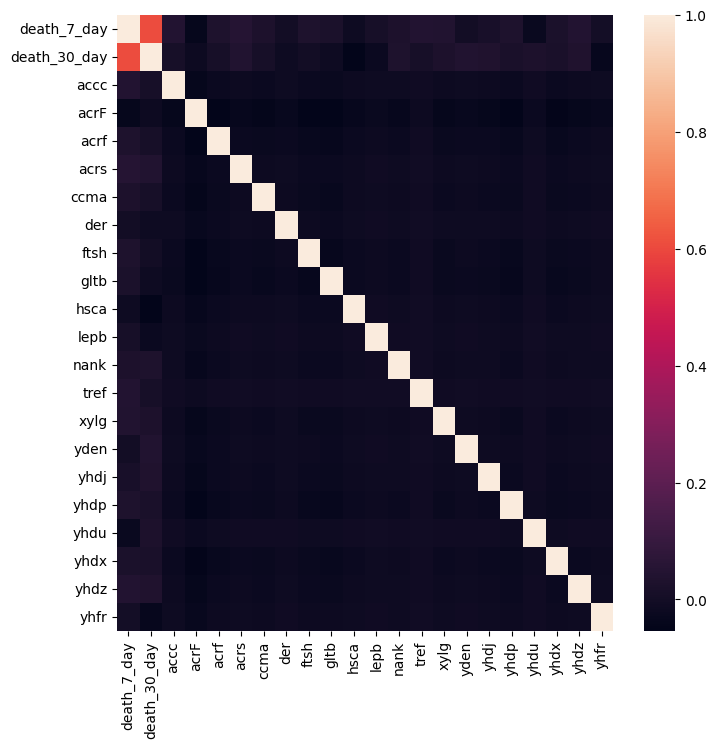

In [87]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm


f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr())

### Plot correlations as a heatmap (Log scale)

<Axes: >

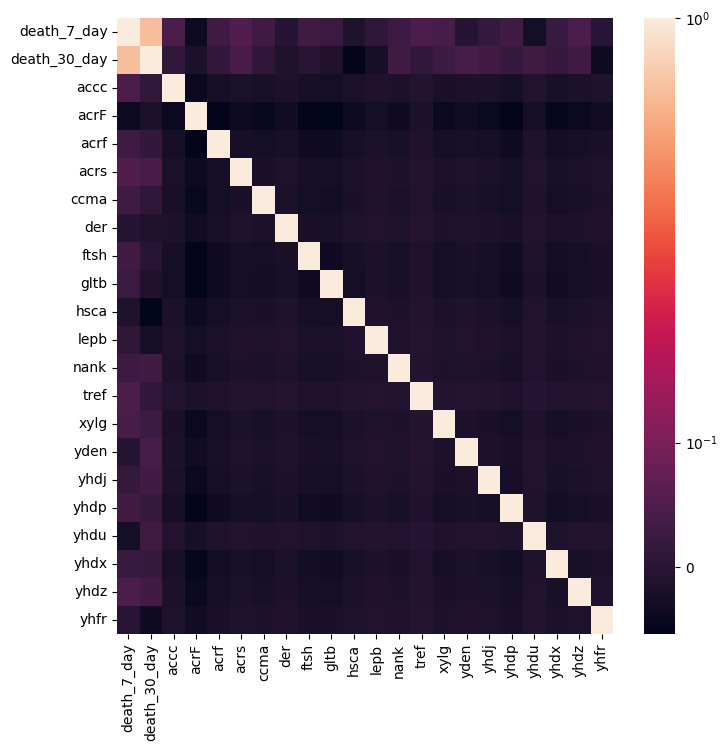

In [88]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm


f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr(), norm=SymLogNorm(linthresh=0.3))

### Plot correlations as a heatmap (Log scale - Sorted)

<Axes: >

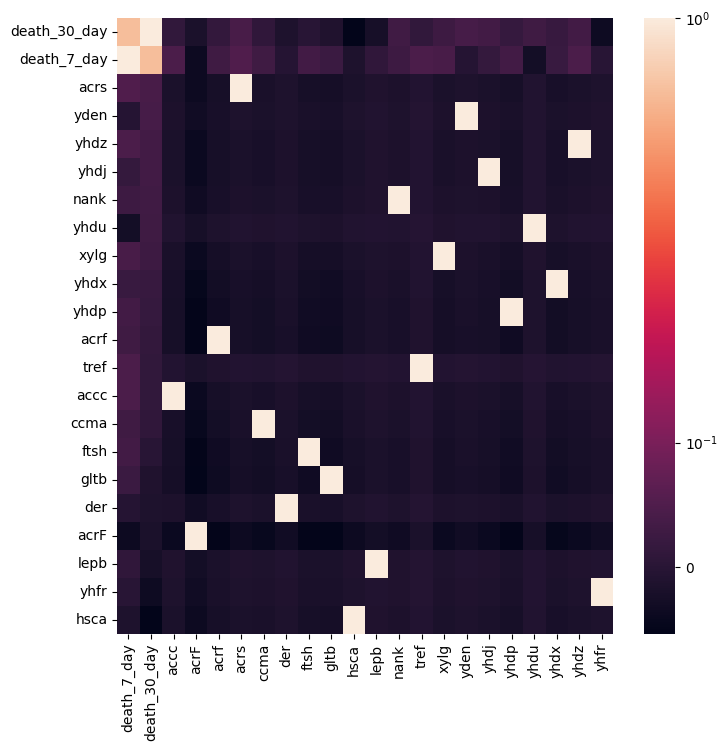

In [89]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm


f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr().sort_values('death_30_day', ascending=False), norm=SymLogNorm(linthresh=0.3))

### Model using machine learning (7 day mortality)

In [90]:
X = dataDf.drop(columns=['person_id', 'JOURNEY_ID', 'death_7_day', 'death_30_day'])
y = dataDf.death_7_day

In [91]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_pred))
print('Average Precision: ', average_precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_pred))

Accuracy:  0.12738853503184713
Balanced Accuracy:  0.483013589128697
Average Precision:  0.11130769835653062
F1 Score:  0.19883040935672514
ROC AUC:  0.483013589128697


In [92]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lrc = LogisticRegression(random_state=0)
y_pred = lrc.fit(X_train, y_train).predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_pred))
print('Average Precision: ', average_precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_pred))

Accuracy:  0.8853503184713376
Balanced Accuracy:  0.5
Average Precision:  0.11464968152866242
F1 Score:  0.0
ROC AUC:  0.5


In [93]:
coefficients = lrc.coef_[0]
featureImportanceDf = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
    }).sort_values(by=['Coefficient'])
featureImportanceDf

,Feature,Coefficient
9,lepb,-0.285435
16,yhdu,-0.285435
1,acrF,-0.095298
0,accc,0.000594
8,hsca,0.055185
2,acrf,0.088006
19,yhfr,0.113821
13,yden,0.113821
5,der,0.113821
17,yhdx,0.171384


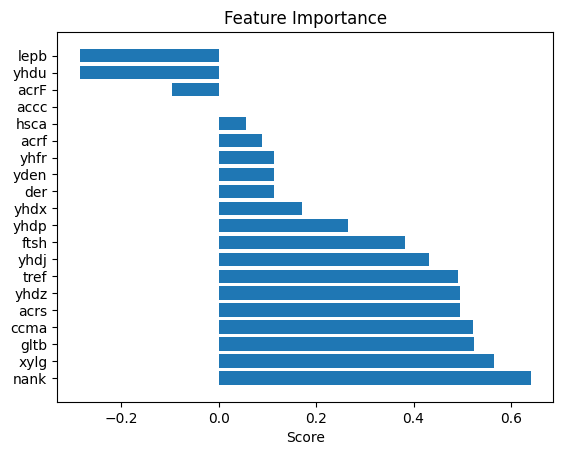

In [94]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()

ax.barh(y=featureImportanceDf.Feature, width=featureImportanceDf.Coefficient, align='center')
# ax.set_yticks(y_pos, labels=people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Score')
ax.set_title('Feature Importance')

plt.show()


### Model using machine learning (30 day mortality)

In [95]:
X = dataDf.drop(columns=['person_id', 'JOURNEY_ID', 'death_7_day', 'death_30_day'])
y = dataDf.death_30_day

In [96]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_pred))
print('Average Precision: ', average_precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_pred))

Accuracy:  0.2929936305732484
Balanced Accuracy:  0.5009615384615385
Average Precision:  0.2551427630133978
F1 Score:  0.4
ROC AUC:  0.5009615384615385


In [97]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lrc = LogisticRegression(random_state=0)
y_pred = lrc.fit(X_train, y_train).predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_pred))
print('Average Precision: ', average_precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_pred))

Accuracy:  0.7452229299363057
Balanced Accuracy:  0.5
Average Precision:  0.25477707006369427
F1 Score:  0.0
ROC AUC:  0.5


In [98]:
coefficients = lrc.coef_[0]
featureImportanceDf = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
    }).sort_values(by=['Coefficient'])
featureImportanceDf

,Feature,Coefficient
9,lepb,-0.587519
8,hsca,-0.476638
19,yhfr,-0.399880
0,accc,-0.142218
6,ftsh,-0.126561
7,gltb,-0.055997
5,der,0.035009
1,acrF,0.098461
14,yhdj,0.119392
15,yhdp,0.141944


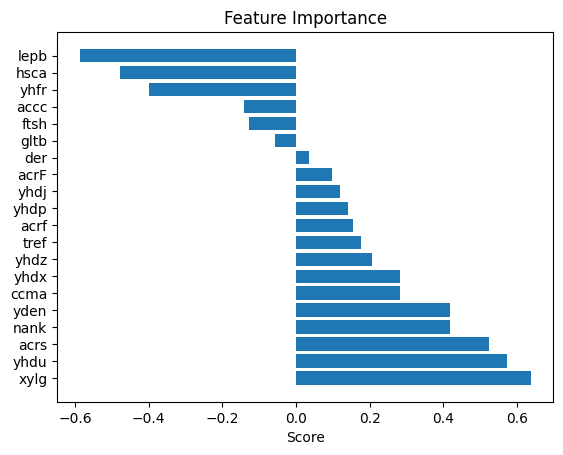

In [99]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()

ax.barh(y=featureImportanceDf.Feature, width=featureImportanceDf.Coefficient, align='center')
# ax.set_yticks(y_pos, labels=people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Score')
ax.set_title('Feature Importance')

plt.show()


## Create tokens data matrix

In [100]:
import numpy as np


tokenWeightedsumDf = highscoreTokenOverlapsDf.groupby(by=['tokens']).agg({'score': np.sum}).reset_index().rename(columns={'score': 'weighted_sum'})
tokenWeightedsumDf

/tmp/ipykernel_3110/457035517.py:4: FutureWarning: The provided callable <function sum at 0x7f262419c3a0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  tokenWeightedsumDf = highscoreTokenOverlapsDf.groupby(by=['tokens']).agg({'score': np.sum}).reset_index().rename(columns={'score': 'weighted_sum'})


,tokens,weighted_sum
0,A,0.747065
1,AAAAA,793.572531
2,AAAAAAAGA,4.656566
3,AAAAAACA,7.139522
4,AAAAAACTG,9.607464
...,...,...
11898,TTTTTTATTCTT,1.471130
11899,TTTTTTC,6.618159
11900,TTTTTTCAT,30.406300
11901,TTTTTTCATCA,1.488444


In [101]:
signatureTokensDf = highscoreTokenOverlapsDf[highscoreTokenOverlapsDf['tokens'].isin(tokenWeightedsumDf.sort_values(by=['weighted_sum'], ascending=False)[:20]['tokens'])]
signatureTokensDf

,contig_id,start_position,end_position,tokens,score,gene,name,tube_code
14,1,3277,3282,GAAAAA,0.117982,taub,taurine ABC transporter ATP-binding subunit,AH19C036
15,1,3277,3282,GAAAAA,0.117982,taub,taurine ABC transporter ATP-binding subunit,AH19C036
16,1,3277,3282,GAAAAA,0.117982,taub,taurine ABC transporter ATP-binding subunit,AH19C036
17,1,3277,3282,GAAAAA,0.117982,taub,taurine ABC transporter ATP-binding subunit,AH19C036
18,1,3277,3282,GAAAAA,0.117982,taub,taurine ABC transporter ATP-binding subunit,AH19C036
...,...,...,...,...,...,...,...,...
2195187,3,362997,363001,ACCGA,0.107262,acrF,multidrug efflux RND transporter permease subunit AcrF,AH21E004
2195188,3,362997,363001,ACCGA,0.107262,acrF,multidrug efflux RND transporter permease subunit AcrF,AH21E004
2195200,5,35015,35019,AATGA,0.116141,sslE,lipoprotein metalloprotease SslE,AH19C036
2195201,5,35085,35090,GGTTTT,0.144816,sslE,lipoprotein metalloprotease SslE,AH19C036


In [102]:
signatureDataDf = signatureTokensDf[['tube_code', 'tokens']].drop_duplicates()
# Get one hot encoding of columns B
one_hot = pd.get_dummies(signatureDataDf['tokens'])
# Drop column B as it is now encoded
signatureDataDf = signatureDataDf.drop('tokens',axis = 1)
# Join the encoded df
signatureDataDf = signatureDataDf.join(one_hot)
signatureDataDf = signatureDataDf.loc[:, (signatureDataDf != 0).any(axis=0)]
signatureDataDf = signatureDataDf*1
signatureDataDf


,tube_code,AAGGC,AATGA,ACCGA,ACGCT,ACGCTG,CACGAT,CATAAA,CCGAC,CGCCGCC,CGGTT,CTGGCG,CTGTTC,GAAAAA,GAAGAAG,GAGTT,GATGAA,GATGCG,GGTTTT,TTAAGC,TTAAT
14,AH19C036,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
28,AH19C036,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
42,AH19C036,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
51,AH19C036,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
84,AH19C036,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2194861,AH21L124,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2194992,AH21G042,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2195001,AH21G042,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2195002,AH21G042,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Create datamatrix

In [111]:
dataDf = mortalityDf.merge(
    mappedJourneyTubeIdsDf,
    on=['person_id', 'JOURNEY_ID'],
    how='inner'
).drop(
    columns=['visit_occurrence_id']
).drop_duplicates().merge(
    signatureDataDf,
    on=['tube_code'],
    how='left'
).drop(
    columns=['tube_code']
)
dataDf = dataDf.fillna(0)
dataDf = dataDf.loc[:, (dataDf != 0).any(axis=0)]
dataDf

,person_id,JOURNEY_ID,death_7_day,death_30_day,AAGGC,AATGA,ACCGA,ACGCT,ACGCTG,CACGAT,CATAAA,CCGAC,CGCCGCC,CGGTT,CTGGCG,CTGTTC,GAAAAA,GAAGAAG,GAGTT,GATGAA,GATGCG,GGTTTT,TTAAGC,TTAAT
0,2154700,10220218,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2145022,601149,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2145022,601149,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2214348,600939,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,307218,601850,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1341,1058066,16759482,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1342,2450777,16762608,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1343,869203,16808421,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1344,2202513,16816295,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Calculate correlation

In [112]:
dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr().sort_values('death_30_day', ascending=False)

,death_7_day,death_30_day,AAGGC,AATGA,ACCGA,ACGCT,ACGCTG,CACGAT,CATAAA,CCGAC,CGCCGCC,CGGTT,CTGGCG,CTGTTC,GAAAAA,GAAGAAG,GAGTT,GATGAA,GATGCG,GGTTTT,TTAAGC,TTAAT
death_30_day,0.608430,1.000000,0.002180,-0.000277,-0.004817,0.013805,-0.003274,0.008072,0.005370,0.023704,0.013805,0.016870,0.004690,0.001677,0.002733,0.007256,0.007256,0.014197,0.014197,-0.007478,0.004690,0.008072
death_7_day,1.000000,0.608430,0.010129,0.008542,0.011753,-0.004390,-0.004390,0.020478,0.018644,0.011753,-0.004390,0.013414,0.011753,0.003977,0.016857,0.013414,0.013414,0.011753,0.011753,-0.001702,0.011753,0.020478
CCGAC,0.011753,0.023704,-0.034189,-0.034580,-0.033794,-0.037944,-0.037944,-0.031755,-0.032172,1.000000,-0.037944,-0.033395,-0.033794,-0.035731,-0.032584,-0.033395,-0.033395,-0.033794,-0.033794,-0.037219,-0.033794,-0.031755
CGGTT,0.013414,0.016870,-0.033785,-0.034172,-0.033395,-0.037496,-0.037496,-0.031380,-0.031792,-0.033395,-0.037496,1.000000,-0.033395,-0.035309,-0.032199,-0.033001,-0.033001,-0.033395,-0.033395,-0.036779,-0.033395,-0.031380
GATGCG,0.011753,0.014197,-0.034189,-0.034580,-0.033794,-0.037944,-0.037944,-0.031755,-0.032172,-0.033794,-0.037944,-0.033395,-0.033794,-0.035731,-0.032584,-0.033395,-0.033395,-0.033794,1.000000,-0.037219,-0.033794,-0.031755
GATGAA,0.011753,0.014197,-0.034189,-0.034580,-0.033794,-0.037944,-0.037944,-0.031755,-0.032172,-0.033794,-0.037944,-0.033395,-0.033794,-0.035731,-0.032584,-0.033395,-0.033395,1.000000,-0.033794,-0.037219,-0.033794,-0.031755
ACGCT,-0.004390,0.013805,-0.038387,-0.038826,-0.037944,1.000000,-0.042603,-0.035654,-0.036122,-0.037944,-0.042603,-0.037496,-0.037944,-0.040119,-0.036585,-0.037496,-0.037496,-0.037944,-0.037944,-0.041789,-0.037944,-0.035654
CGCCGCC,-0.004390,0.013805,-0.038387,-0.038826,-0.037944,-0.042603,-0.042603,-0.035654,-0.036122,-0.037944,1.000000,-0.037496,-0.037944,-0.040119,-0.036585,-0.037496,-0.037496,-0.037944,-0.037944,-0.041789,-0.037944,-0.035654
CACGAT,0.020478,0.008072,-0.032126,-0.032494,-0.031755,-0.035654,-0.035654,1.000000,-0.030231,-0.031755,-0.035654,-0.031380,-0.031755,-0.033576,-0.030618,-0.031380,-0.031380,-0.031755,-0.031755,-0.034973,-0.031755,-0.029839
TTAAT,0.020478,0.008072,-0.032126,-0.032494,-0.031755,-0.035654,-0.035654,-0.029839,-0.030231,-0.031755,-0.035654,-0.031380,-0.031755,-0.033576,-0.030618,-0.031380,-0.031380,-0.031755,-0.031755,-0.034973,-0.031755,1.000000


### Plot correlations as a heatmap

<Axes: >

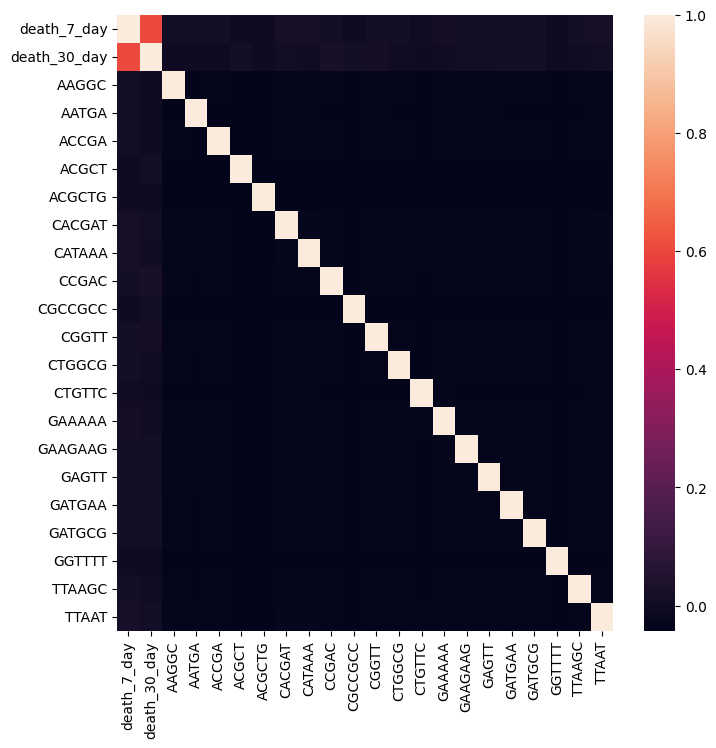

In [113]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm


f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr())

### Plot correlations as a heatmap (Log scale)

<Axes: >

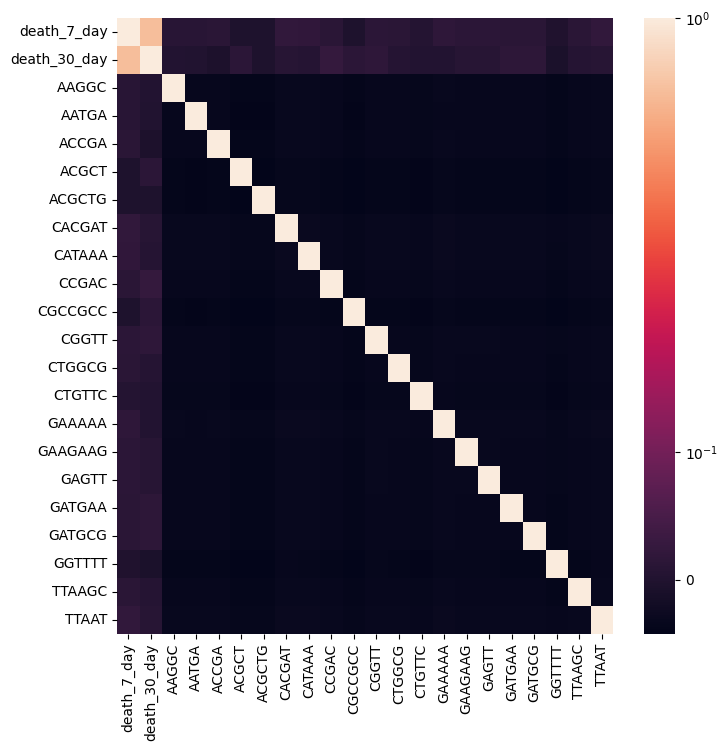

In [114]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm


f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr(), norm=SymLogNorm(linthresh=0.3))

### Plot correlations as a heatmap (Log scale - Sorted)

<Axes: >

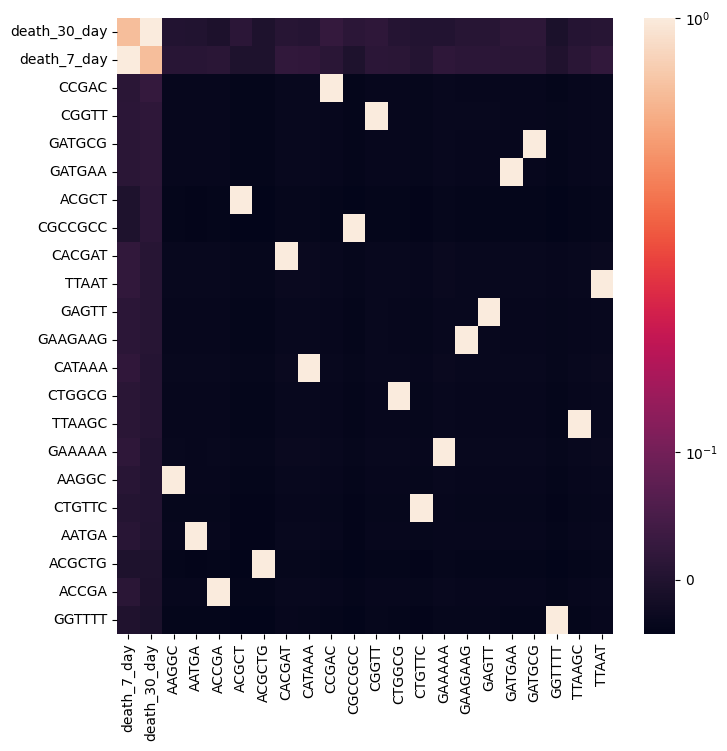

In [115]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm


f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr().sort_values('death_30_day', ascending=False), norm=SymLogNorm(linthresh=0.3))

### Model using machine learning (7 day)

In [116]:
X = dataDf.drop(columns=['person_id', 'JOURNEY_ID', 'death_30_day', 'death_7_day'])
y = dataDf.death_7_day

In [117]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_pred))
print('Average Precision: ', average_precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_pred))

Accuracy:  0.6444444444444445
Balanced Accuracy:  0.46458333333333335
Average Precision:  0.10560185185185184
F1 Score:  0.12727272727272726
ROC AUC:  0.46458333333333335


In [118]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lrc = LogisticRegression(random_state=0)
y_pred = lrc.fit(X_train, y_train).predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_pred))
print('Average Precision: ', average_precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_pred))

Accuracy:  0.8888888888888888
Balanced Accuracy:  0.5
Average Precision:  0.1111111111111111
F1 Score:  0.0
ROC AUC:  0.5


In [119]:
coefficients = lrc.coef_[0]
featureImportanceDf = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
    }).sort_values(by=['Coefficient'])
featureImportanceDf

,Feature,Coefficient
18,TTAAGC,0.100261
4,ACGCTG,0.115872
10,CTGGCG,0.148702
16,GATGCG,0.174071
15,GATGAA,0.174071
8,CGCCGCC,0.174711
3,ACGCT,0.241286
11,CTGTTC,0.264230
17,GGTTTT,0.268061
7,CCGAC,0.312183


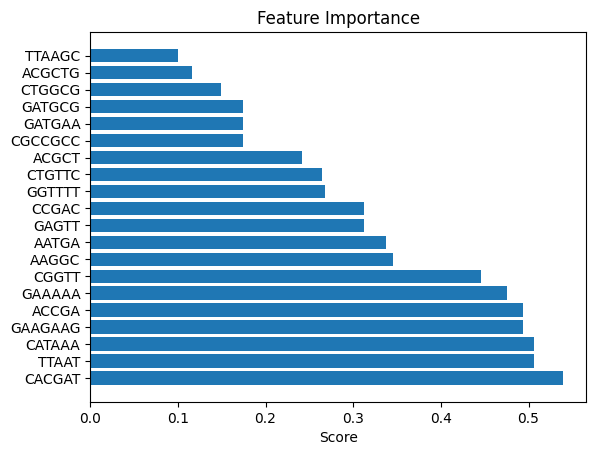

In [120]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()

ax.barh(y=featureImportanceDf.Feature, width=featureImportanceDf.Coefficient, align='center')
# ax.set_yticks(y_pos, labels=people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Score')
ax.set_title('Feature Importance')

plt.show()

### Model using machine learning (30 day)

In [121]:
X = dataDf.drop(columns=['person_id', 'JOURNEY_ID', 'death_30_day', 'death_7_day'])
y = dataDf.death_30_day

In [122]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_pred))
print('Average Precision: ', average_precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_pred))

Accuracy:  0.5296296296296297
Balanced Accuracy:  0.43641025641025644
Average Precision:  0.2596210163652024
F1 Score:  0.2111801242236025
ROC AUC:  0.4364102564102563


In [123]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lrc = LogisticRegression(random_state=0)
y_pred = lrc.fit(X_train, y_train).predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_pred))
print('Average Precision: ', average_precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_pred))

Accuracy:  0.7222222222222222
Balanced Accuracy:  0.5
Average Precision:  0.2777777777777778
F1 Score:  0.0
ROC AUC:  0.5


In [124]:
coefficients = lrc.coef_[0]
featureImportanceDf = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
    }).sort_values(by=['Coefficient'])
featureImportanceDf

,Feature,Coefficient
4,ACGCTG,-0.185896
1,AATGA,-0.050460
12,GAAAAA,-0.037367
19,TTAAT,-0.001220
16,GATGCG,0.012698
17,GGTTTT,0.111456
10,CTGGCG,0.116746
14,GAGTT,0.177167
18,TTAAGC,0.177167
5,CACGAT,0.195592


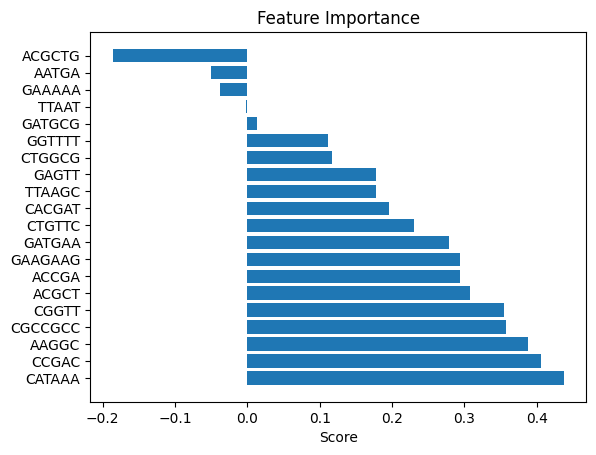

In [125]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()

ax.barh(y=featureImportanceDf.Feature, width=featureImportanceDf.Coefficient, align='center')
# ax.set_yticks(y_pos, labels=people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Score')
ax.set_title('Feature Importance')

plt.show()

### Get genes corresponding to the top tokens

#### Token `ACGCTG` (-ve feature importance)

In [126]:
highscoreTokenOverlapsDf[highscoreTokenOverlapsDf.tokens == 'ACGCTG'][['gene']].value_counts()[:20]

gene
mdh     1135
nusa     613
der      609
sinh     603
ftsh     348
yraq     323
degq     314
zape     305
mtr      275
skp      258
yejb     257
fole     236
leus     227
yehq     208
yehp     208
cusb     198
yccs     194
ftsp     192
pat      190
nuoe     187
Name: count, dtype: int64

`mdh`: Malate dehydrogenase catalyzes the interconversion of malate and oxaloacetate. It participates as a member of the tricarboxylic acid cycle and the branched noncyclic pathways under aerobic and anaerobic cell growth conditions, respectively

#### Token `CATAAA` (-ve feature importance)

In [127]:
highscoreTokenOverlapsDf[highscoreTokenOverlapsDf.tokens == 'CATAAA'][['gene']].value_counts()[:20]

gene
argg    310
acrd    277
fima    269
yfeh    219
nagb    208
suca    190
euta    183
emrk    180
enda    178
fepc    175
spef    160
yfal    130
arna    124
ybir    122
ydhy    116
adra    115
gntr    115
tomb    113
pnca    112
ybdl    112
Name: count, dtype: int64

`AcrD`: The Escherichia coli acriflavine resistance protein D (AcrD) is an efflux pump that belongs to the resistance-nodulation-cell division (RND) superfamily. Its primary function is to provide resistance to aminoglycoside-based drugs by actively extruding these noxious compounds out of E. coli cells

`fimA`: The fimA gene in Escherichia coli (E. coli) encodes a major subunit of type 1 fimbriae, a type of bacterial pilus that helps the bacterium adhere to surfaces. FimA is essential for E. coli to colonize and invade host tissues. It also plays a role in biofilm formation and can affect L-threonine carbon distribution within E. coli